# Pipeline
in this file we build a pipeline to load (local) fmnist csv dataset, preprocess (maybe), and train an AE (simple not conv). 

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## import data

import csv as data frame (pandas) and convert to nparray

In [3]:
df_train = pd.read_csv('archive/fashion-mnist_train.csv') # df for dataframe
df_test = pd.read_csv('archive/fashion-mnist_test.csv')


separate labels
X_train.pop pops specific features (original feature is deleted in X_train)

In [4]:
labels_train = df_train.pop('label')
labels_test = df_test.pop('label')
#labels_train

create sklearn pipeline for normalizing

In [5]:
#normalize = Pipeline(steps = ['minmax_normalize', MinMaxScaler()]) # choose transform

In [6]:
normalize = MinMaxScaler() # choose transform
normalize.fit(df_train); # fit transform
df_train_normalized = np.single(normalize.transform(df_train)) # is np.single() command necessary? 
df_test_normalized = np.single(normalize.transform(df_test))

reshape from vector to img

In [7]:
X_train = df_train_normalized.reshape(-1,28,28)
X_test = df_test_normalized.reshape(-1,28,28)

## build AE
design AE as specific architecture 
    right now: simple layer


In [8]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

In [9]:
input_img = Input(shape=(28,28,1))
input_encoded = Input(shape=(7,7,4))

# model: encoder
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
encoder = Model(input_img, encoded)


In [8]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           580       
Total params: 5,524
Trainable params: 5,524
Non-trainable params: 0
___________________________________________________________

In [11]:
# model: decoder
decoded = Conv2D(4, (3, 3), activation='relu', padding='same')(input_encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
decoder = Model(input_encoded, decoded)

#decoder.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 7, 4)]         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 16)          592       
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 1)         289       
Total params: 5,521
Trainable params: 5,521
Non-trainable params: 0
_________________________________________________________

In [12]:
# model: autoencoder (encoder + decoder)
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 7, 7, 4)           5524      
_________________________________________________________________
model_2 (Functional)         (None, 28, 28, 1)         5521      
Total params: 11,045
Trainable params: 11,045
Non-trainable params: 0
_________________________________________________________________


## train AE

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12833659641826743036
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4181262336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10212649292716162307
physical_device_desc: "device: 0, name: GeForce GTX 1660 SUPER, pci bus id: 0000:08:00.0, compute capability: 7.5"
]


In [15]:
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=256,
                validation_data=(X_test, X_test),
                verbose=1)

Epoch 1/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2694 - val_loss: 0.2675
Epoch 2/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2688 - val_loss: 0.2670
Epoch 3/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2683 - val_loss: 0.2665
Epoch 4/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2678 - val_loss: 0.2660
Epoch 5/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2673 - val_loss: 0.2657
Epoch 6/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2669 - val_loss: 0.2651
Epoch 7/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2665 - val_loss: 0.2649
Epoch 8/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2662 - val_loss: 0.2645
Epoch 9/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2658 - val_loss: 0.2646
Epoch 10/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2656 - val_lo

In [16]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

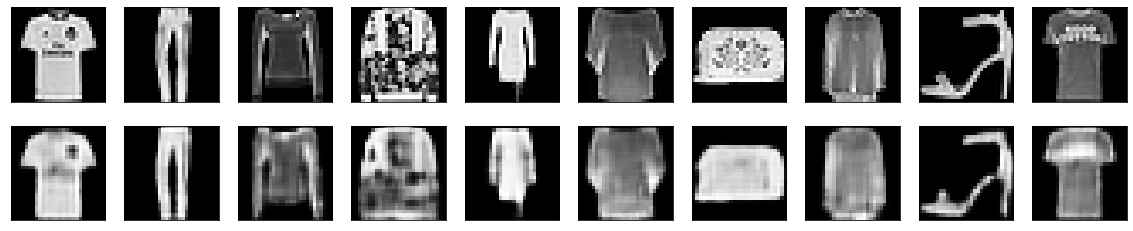

In [17]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(X_test_normalized[i].reshape(28, 28))
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()